In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# can create unsolvable tubes
def gen_randTubes(n_filled, n_empty=2, seed=None):
  if seed is not None:
    rng = np.random.default_rng(seed)
  colrs = plt.cm.viridis(np.linspace(0,1,n_filled))[:,:-1]
  tubes = [[list(colr)]*4 for colr in colrs]
  tubes_flat = [colr for tube in tubes for colr in tube]
  np.random.shuffle(tubes_flat)
  tubes = [tubes_flat[i:i+4] for i in range(0, len(tubes_flat), 4)]
  for _ in range(n_empty):
    tubes.append([[1,1,1]]*4)
  return tubes

In [3]:
def gen_seqTubes(n_filled, n_empty=2):
  colrs = plt.cm.viridis(np.linspace(0,1,n_filled))[:,:-1]
  tubes = [[list(colr)]*4 for colr in colrs]
  for _ in range(n_empty):  tubes.append([[1,1,1]]*4)
  return tubes

In [4]:
def copytubes(tubes):
  new_tubes = [list(tube) for tube in tubes]
  return new_tubes

In [5]:
def nonEmptyIndex(tube):
  i=0
  while i in range(len(tube)):
    if tube[i] != [1,1,1]:
      break
    i+=1
  return i

In [6]:
def check_transfer(tube1,tube2):

  # check if colr matches
  t1_indx = nonEmptyIndex(tube1)
  t2_indx = nonEmptyIndex(tube2)

  if t1_indx == len(tube1):  # tube1 should not be empty
    return False
  elif t2_indx == 0:  # tube2 should not be full
    return False

  if t1_indx < len(tube1)-1:  # if tube has more than 1 patch
    t1_colr = tube1[t1_indx]
    if t1_colr != tube1[t1_indx+1]:  # check if color of the patch below matches
      return False

  return True

In [8]:
def transfer_rev(tube1,tube2):

  # check if colr matches
  t1_indx = nonEmptyIndex(tube1)
  t2_indx = nonEmptyIndex(tube2)
  t1_colr = tube1[t1_indx]


  t1_chunk = 1
  i = t1_indx + 1
  while i < len(tube1) and tube1[i] == t1_colr:
    if i < len(tube1) - 1 and tube1[i+1] != t1_colr:
      break
    t1_chunk += 1
    i += 1

  t2_space = t2_indx
  if t1_chunk < t2_space:
    chunk_size = np.random.randint(1, t1_chunk+1)
  else:
    chunk_size = np.random.randint(1, t2_indx+1) 
  

  i = t1_indx
  while i in range(t1_indx + chunk_size):
    j = (t2_indx-1) - (i-t1_indx)
    if (tube1[i] != t1_colr) or (j == -1):
      break
    tube2[j] = tube1[i]
    tube1[i] = [1,1,1]
    i+=1

  return chunk_size

In [9]:
def tubes_score(tubes):
  total_score = 0
  for tube in tubes:
    t_indx = nonEmptyIndex(tube)
    if t_indx != len(tube):
      score=1; colr=tube[t_indx]
      for i in range(t_indx+1, len(tube)):
        # for n consecutive colors in a tube
        # score is given as 4^n
        if tube[i] == colr:
          score *= 4
        else:
          if score > 1:
            total_score += score
          colr = tube[i]
          score = 1
      if score > 1:
        total_score += score
    # subtract 1 for every empty tube
    # so that initial moves would have higher score than tubes being empty
    else:
      total_score -= 1    
  return total_score

In [10]:
def shuffle_tubes(original_tubes, n_trials, seed=None):
  tubes = copytubes(original_tubes)
  moves_tested = []
  n_possibleMoves = np.math.factorial(len(tubes))/(2*np.math.factorial(len(tubes)-2))
  moves = []
  visited_states = [tubes]
  prev_score = 64*len(tubes)
  if seed is not None:
      rng = np.random.default_rng(seed)

  for _ in range(n_trials):
    move_indx = 1
    # transfer from tube1 to tube2
    if len(moves_tested) == n_possibleMoves:
      break
    while True:
      i,j = np.random.choice(range(len(tubes)),2,replace=False)
      if (i,j) not in moves_tested and (j,i) not in moves_tested:
        moves_tested.append((i,j))
        break

    transferred = False
    tube1, tube2 = tubes[i], tubes[j]
    if check_transfer(tube1,tube2):
      new_tubes = copytubes(tubes)
      chunk_size = transfer_rev(new_tubes[i], new_tubes[j])
      #score = tubes_score(new_tubes)
      if new_tubes not in visited_states:
        moves.append(((i,j),chunk_size))
        transferred = True
    if (not transferred) and (check_transfer(tube2,tube1)):
      new_tubes = copytubes(tubes)
      chunk_size = transfer_rev(new_tubes[j], new_tubes[i])
      #score = tubes_score(new_tubes)
      if new_tubes not in visited_states:
        moves.append( ((j,i),chunk_size) )
        transferred = True
    if transferred:
      move_indx += 1
      moves_tested = []
      tubes = new_tubes
      visited_states.append(tubes)


  # swap the moves since solving would require reverse transfer
  movesRev = [((j,i), chunk_size) for (i,j), chunk_size in moves]
  # reverse the sequence of moves as well
  movesRev = list(reversed(movesRev))
  movesRevShort = list(movesRev)
  while True:
    new_moves = []
    found_dupli=False
    for i, (move,chunk_size) in enumerate(movesRevShort[:-1]):
      if move!=movesRevShort[i+1][0] and move!=reversed(movesRevShort[i+1][0]):
        new_moves.append((move,chunk_size))
      else:
        found_dupli=True
    if new_moves[-1] != movesRevShort[-1]:  new_moves.append(movesRevShort[-1])
    movesRevShort = new_moves
    if not found_dupli:
      break

  
  return tubes, moves, movesRev, movesRevShort

In [11]:
tubes = gen_seqTubes(10)
solvedTubes, moves, movesRev, movesRevShort = shuffle_tubes(tubes, 1000)

In [13]:
from colorsort_game import plot_tubes,testGame

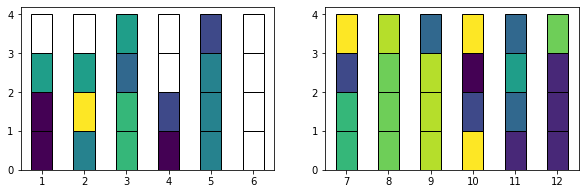

score : 75
move:1 -> transfer tube2 to tube1, chunk_size=1


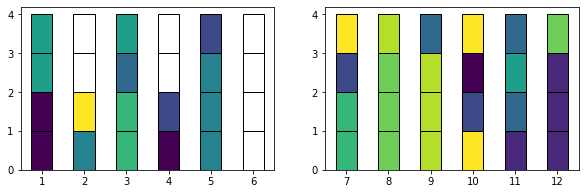

score : 79
move:2 -> transfer tube1 to tube6, chunk_size=1


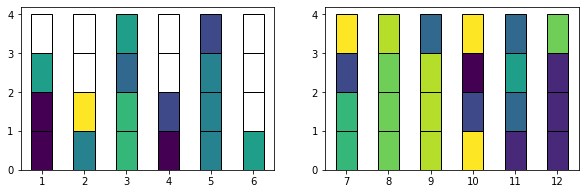

score : 76
move:3 -> transfer tube3 to tube6, chunk_size=1


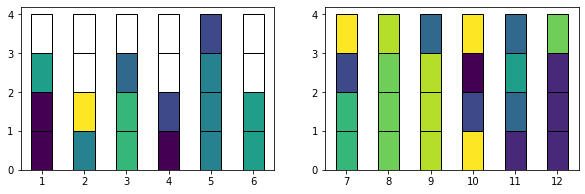

score : 80
move:4 -> transfer tube7 to tube2, chunk_size=1


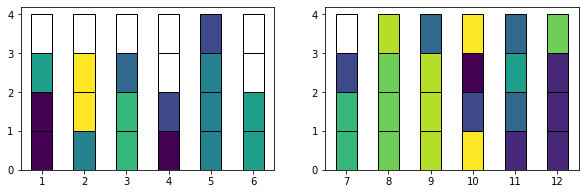

score : 84
move:5 -> transfer tube1 to tube6, chunk_size=1


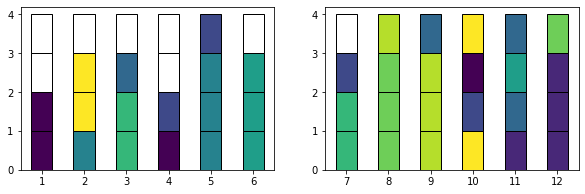

score : 96
move:6 -> transfer tube4 to tube7, chunk_size=1


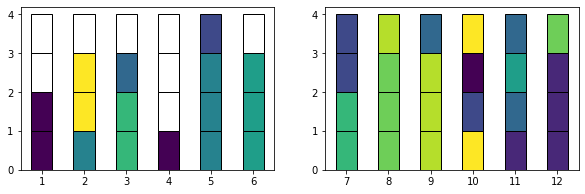

score : 100
move:7 -> transfer tube10 to tube2, chunk_size=1


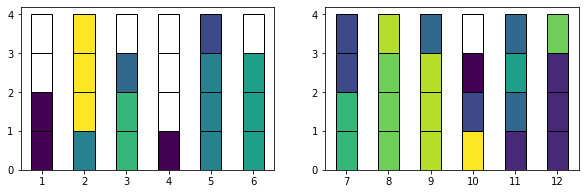

score : 112
move:8 -> transfer tube4 to tube10, chunk_size=1


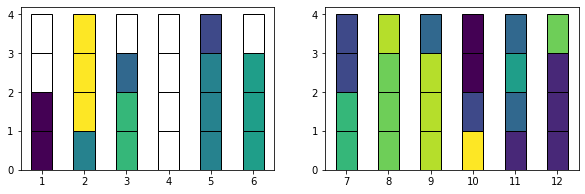

score : 115
move:9 -> transfer tube10 to tube1, chunk_size=2


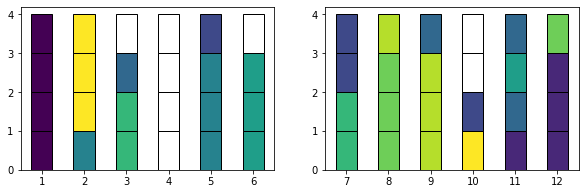

score : 171
move:10 -> transfer tube11 to tube4, chunk_size=1


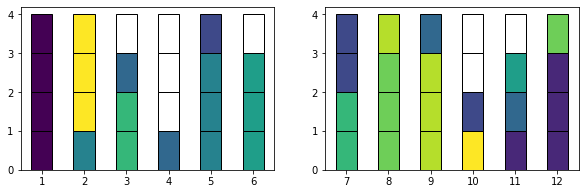

score : 172
move:11 -> transfer tube7 to tube10, chunk_size=2


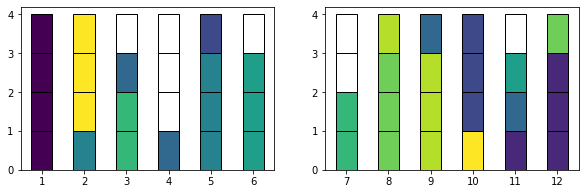

score : 184
move:12 -> transfer tube3 to tube4, chunk_size=1


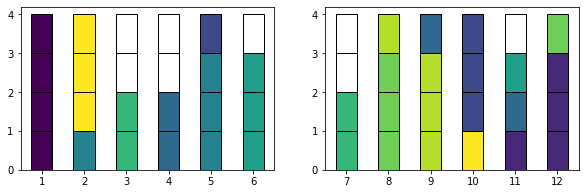

score : 188
move:13 -> transfer tube3 to tube7, chunk_size=2


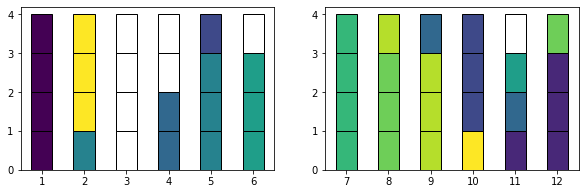

score : 243
move:14 -> transfer tube11 to tube6, chunk_size=1


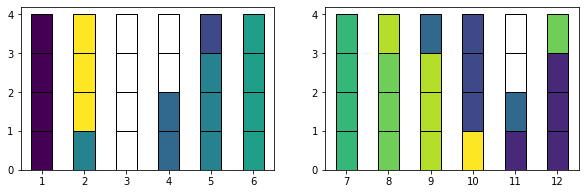

score : 291
move:15 -> transfer tube11 to tube4, chunk_size=1


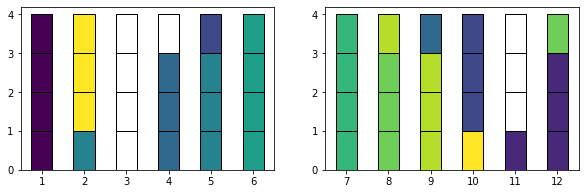

score : 303
move:16 -> transfer tube11 to tube3, chunk_size=1


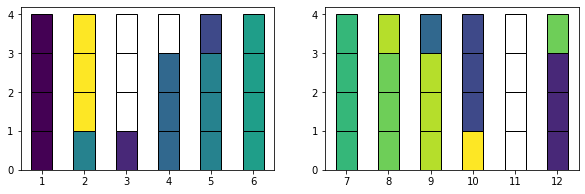

score : 303
move:17 -> transfer tube9 to tube4, chunk_size=1


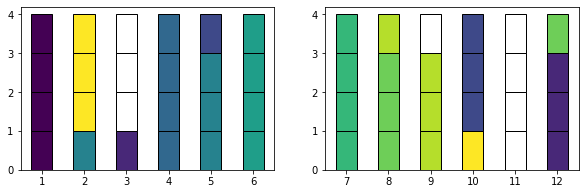

score : 351
move:18 -> transfer tube3 to tube11, chunk_size=1


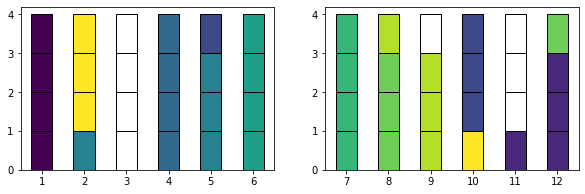

score : 351
move:19 -> transfer tube10 to tube3, chunk_size=3


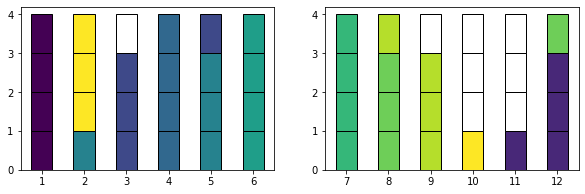

score : 352
move:20 -> transfer tube8 to tube9, chunk_size=1


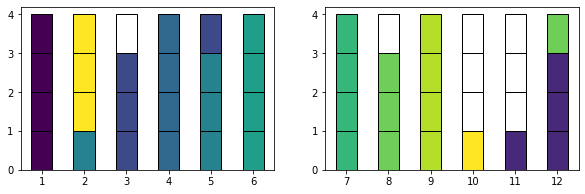

score : 400
move:21 -> transfer tube2 to tube10, chunk_size=3


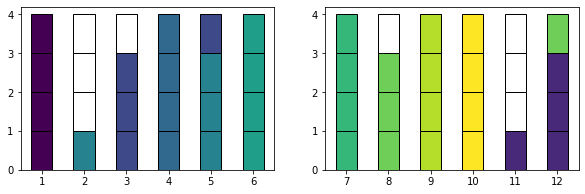

score : 448
move:22 -> transfer tube12 to tube8, chunk_size=1


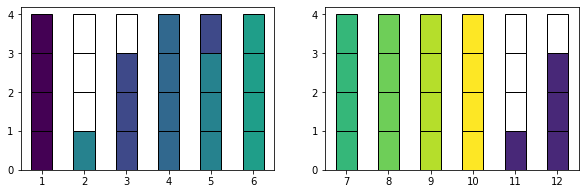

score : 496
move:23 -> transfer tube5 to tube3, chunk_size=1


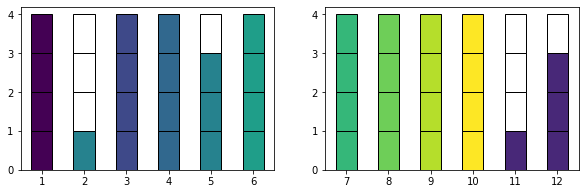

score : 544
move:24 -> transfer tube2 to tube5, chunk_size=1


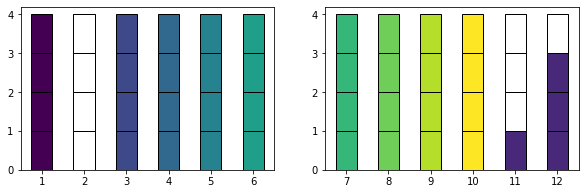

score : 591
move:25 -> transfer tube12 to tube2, chunk_size=3


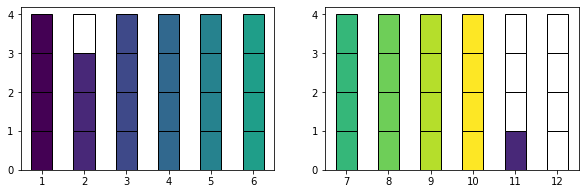

score : 591
move:26 -> transfer tube11 to tube2, chunk_size=1


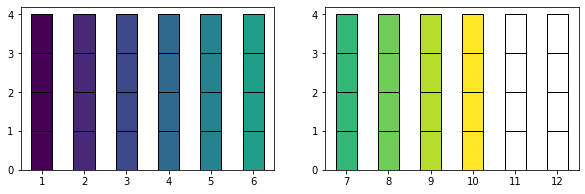

score : 638


In [14]:
testGame(solvedTubes, movesRev)

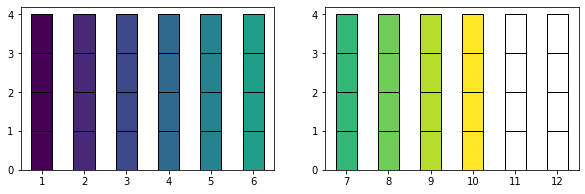

score : 638
move:1 -> transfer tube2 to tube11, chunk_size=1


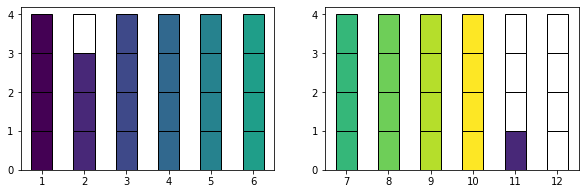

score : 591
move:2 -> transfer tube2 to tube12, chunk_size=3


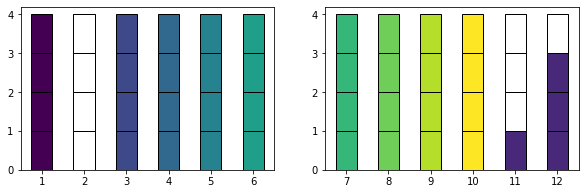

score : 591
move:3 -> transfer tube5 to tube2, chunk_size=1


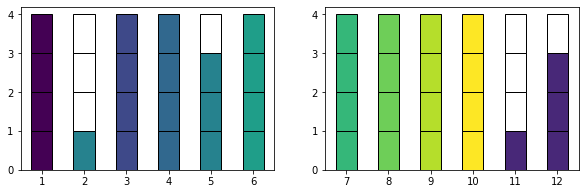

score : 544
move:4 -> transfer tube3 to tube5, chunk_size=1


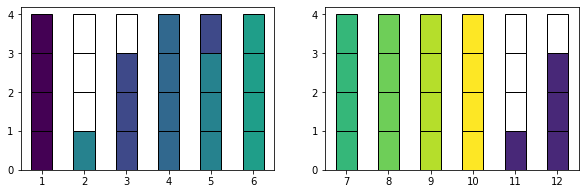

score : 496
move:5 -> transfer tube8 to tube12, chunk_size=1


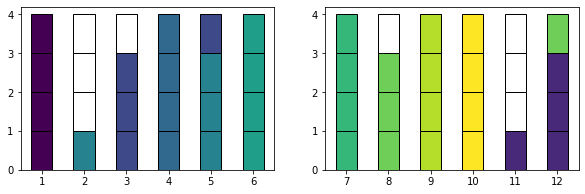

score : 448
move:6 -> transfer tube10 to tube2, chunk_size=3


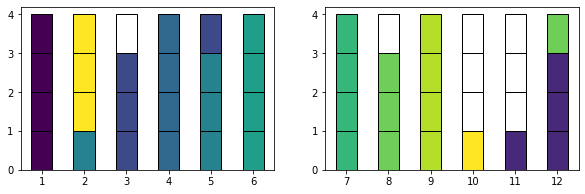

score : 400
move:7 -> transfer tube9 to tube8, chunk_size=1


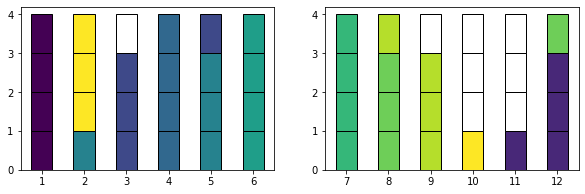

score : 352
move:8 -> transfer tube3 to tube10, chunk_size=3


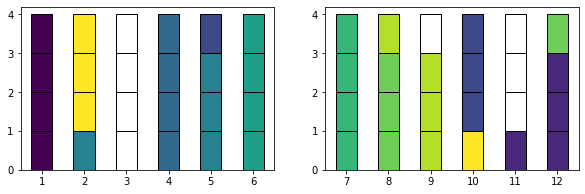

score : 351
move:9 -> transfer tube11 to tube3, chunk_size=1


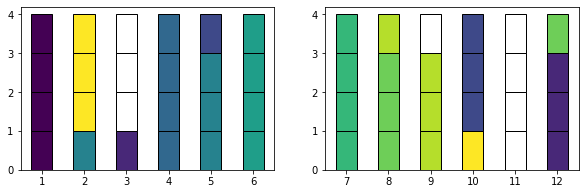

score : 351
move:10 -> transfer tube4 to tube9, chunk_size=1


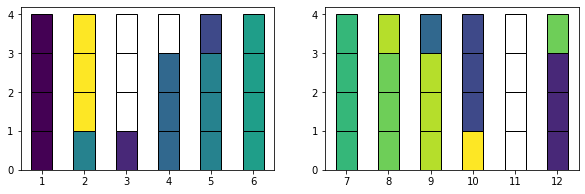

score : 303
move:11 -> transfer tube3 to tube11, chunk_size=1


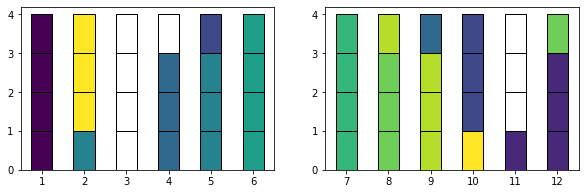

score : 303
move:12 -> transfer tube4 to tube11, chunk_size=1


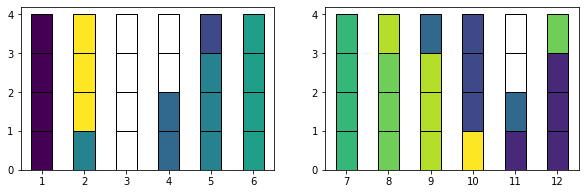

score : 291
move:13 -> transfer tube6 to tube11, chunk_size=1


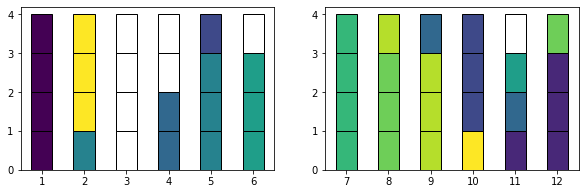

score : 243
move:14 -> transfer tube7 to tube3, chunk_size=2


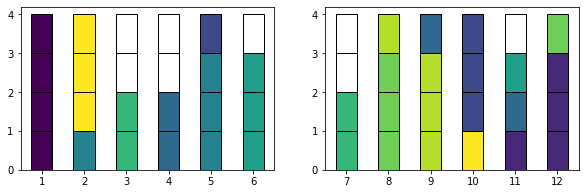

score : 188
move:15 -> transfer tube4 to tube3, chunk_size=1


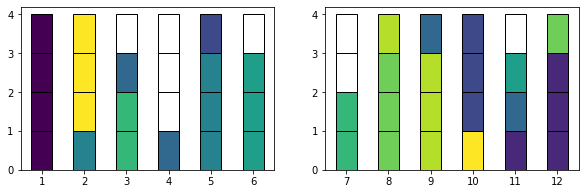

score : 184
move:16 -> transfer tube10 to tube7, chunk_size=2


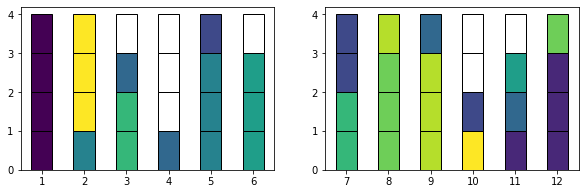

score : 172
move:17 -> transfer tube4 to tube11, chunk_size=1


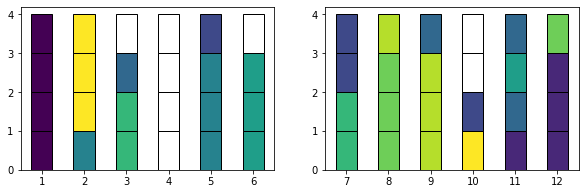

score : 171
move:18 -> transfer tube1 to tube10, chunk_size=2


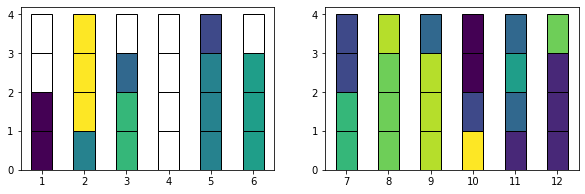

score : 115
move:19 -> transfer tube10 to tube4, chunk_size=1


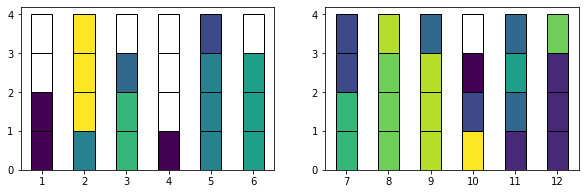

score : 112
move:20 -> transfer tube2 to tube10, chunk_size=1


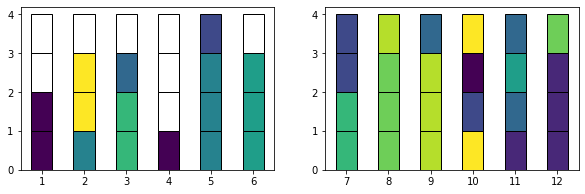

score : 100
move:21 -> transfer tube7 to tube4, chunk_size=1


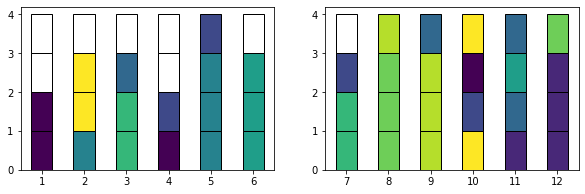

score : 96
move:22 -> transfer tube6 to tube1, chunk_size=1


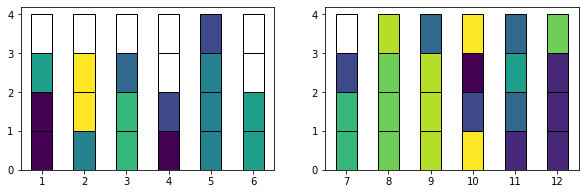

score : 84
move:23 -> transfer tube2 to tube7, chunk_size=1


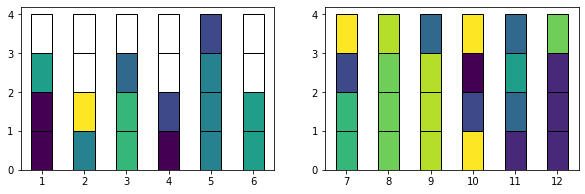

score : 80
move:24 -> transfer tube6 to tube3, chunk_size=1


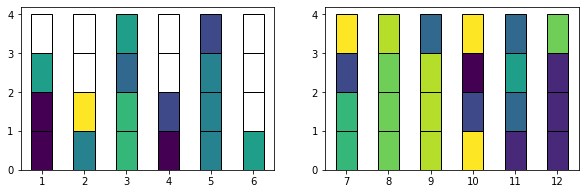

score : 76
move:25 -> transfer tube6 to tube1, chunk_size=1


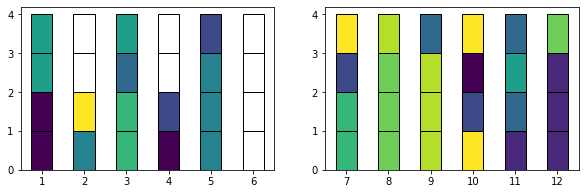

score : 79
move:26 -> transfer tube1 to tube2, chunk_size=1


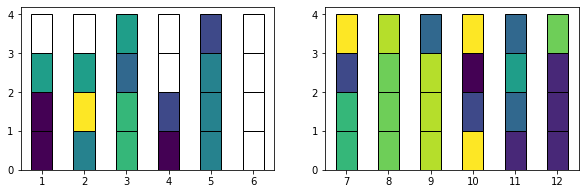

score : 75


In [15]:
testGame(tubes, moves)